In [1]:
%matplotlib inline
import quantstats_custom as qs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
def vdir(obj):
    return [x for x in dir(obj) if not x.startswith('__')]
# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [2]:
# fetch the daily returns for a stock
tickerName = 'BTC-USD'
stock = qs.utils.download_returns(tickerName)

sharpe=0.803596787351027
return=37.011353189436996
momentum         mean=0.8427876805601598
momentum_simple  mean=0.8705135323553183
rolling_sharpe   mean=0.886599509778404
hodl             mean=1.0


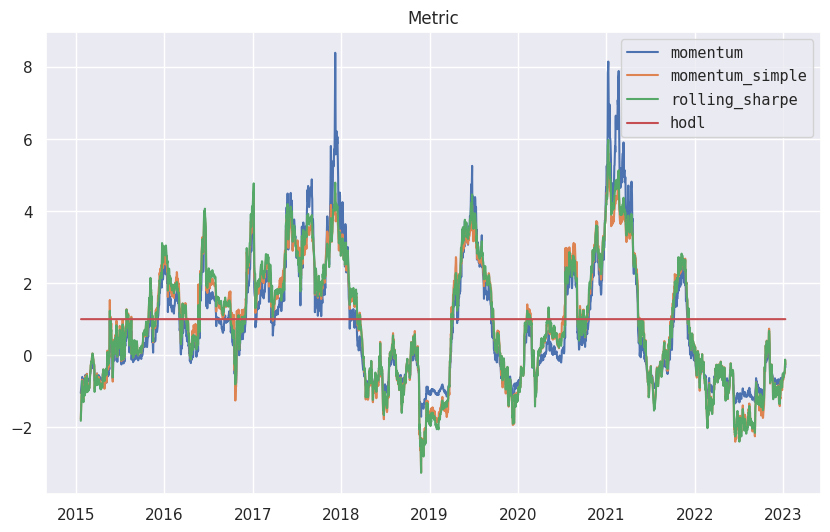

In [3]:
print('sharpe={}'.format(stock.sharpe()))
print('return={}'.format((stock+1).prod()-1))
def no_signal(returns=stock,rolling_period=30):
    return returns.rolling(rolling_period).apply(lambda x: 1)

rolling_period = 21*6
signals={'momentum':{'function':qs.stats.momentum},'momentum_simple':{'function':qs.stats.momentum_simple}\
    ,'rolling_sharpe':{'function':qs.stats.rolling_sharpe}\
    ,'hodl':{'function':no_signal}\
        }
for name,signal in signals.items():
    signal['metric'] = signal['function'](returns=stock,rolling_period=rolling_period)
    print('{:16s} mean={}'.format(name,signal['metric'].mean()))
    plt.plot(signal['metric'],label=name)
plt.legend(prop={'family' : 'monospace'})
plt.title('Metric')
plt.show()


momentum         signal mean=0.766715828311532
momentum_simple  signal mean=0.766715828311532
rolling_sharpe   signal mean=0.766715828311532
hodl             signal mean=0.7667158283115321


,Close,Close,Close,Close,Close
Date,,,,,
2017-01-01 00:00:00+00:00,0.035883,0.008147,0.007677,0.007655,0.005570
2017-01-02 00:00:00+00:00,0.023464,0.005327,0.005020,0.005006,0.003642


,Close,Close,Close,Close,Close
Date,,,,,
2023-01-10 00:00:00+00:00,0.014523,-0.250850,-0.130977,-0.123271,1.0
2023-01-11 00:00:00+00:00,-0.003577,-0.338037,-0.265448,-0.248812,1.0


momentum         cagr=17.82% sharpe=1.182 vol=10.00% sortino=1.849
momentum_simple  cagr=17.97% sharpe=1.191 vol=10.00% sortino=1.861
rolling_sharpe   cagr=17.95% sharpe=1.190 vol=10.00% sortino=1.858
hodl             cagr=12.11% sharpe=0.839 vol=10.00% sortino=1.233
three_signals    cagr=17.97% sharpe=1.191 vol=10.00% sortino=1.861


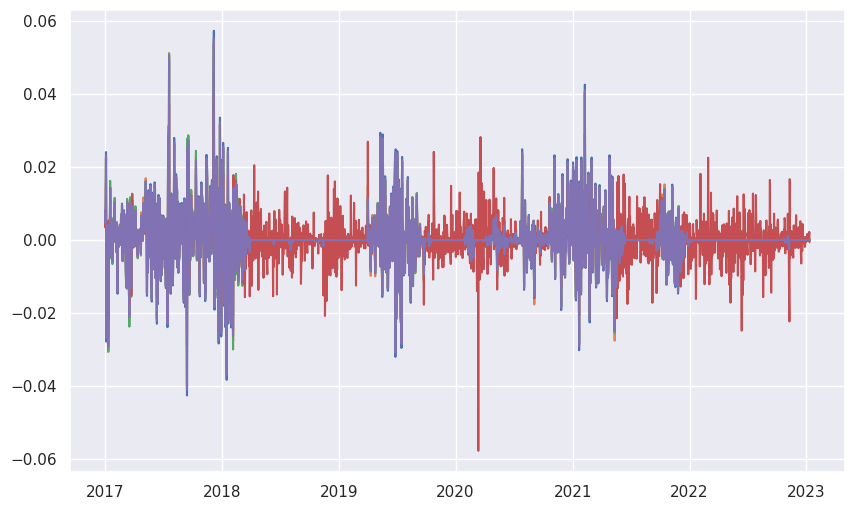

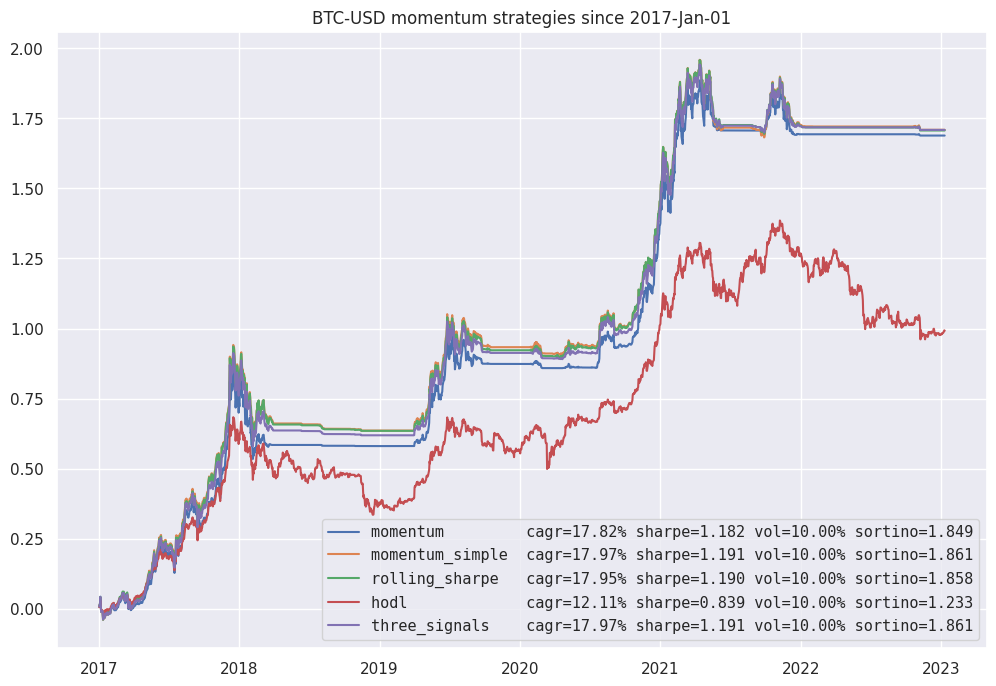

In [4]:
shift_amount=1
min_clip=0
max_clip=2
add_amount=0
divide_amount=1
start_date = pd.to_datetime('2017-01-01', utc=True)
# max_date_1_before = max_date - pd.Timedelta(days=1)
stock_series = stock.loc[stock.index>=start_date]
label = '{:16s} cagr={:6.2%} sharpe={:5.3f} vol={:6.2%} sortino={:5.3f}'

returns=stock_series
metrics=stock_series
for name,signal in signals.items():
    signal['signal'] = signal['metric'].shift(shift_amount)
    signal['signal'] = np.clip(signal['signal'],min_clip,max_clip)
    signal['signal'] = (signal['signal']+add_amount)/divide_amount
    # signal['signal'] = signal['signal'].loc[stock.index>=start_date]
    signal['signal'] = signal['signal']*signals['momentum']['signal'].mean()/signal['signal'].mean()
    print('{:16s} signal mean={}'.format(name,signal['signal'].mean()))
    signal['return'] = stock_series*(signal['signal'].loc[stock.index>=start_date])
    signal['return'] = signal['return']*0.1/qs.stats.volatility(signal['return']) # normalize to 10% volatility
    returns=pd.concat([returns,signal['return']],axis=1)
    metrics=pd.concat([metrics,signal['metric']],axis=1)
display(returns.head(2))
display(metrics.tail(2))

# add a new signal
signals['three_signals']={'return':signals['hodl']['metric'].loc[stock.index>=start_date]-1}
# display(signals['three_signals'])
for name,signal in signals.items():
    if name!='hodl':
        signals['three_signals']['return']=signals['three_signals']['return']+signal['return']/len(signals.items())
signals['three_signals']['return']=signals['three_signals']['return']*0.1/qs.stats.volatility(signals['three_signals']['return'])
for name,signal in signals.items():
    plt.plot(signal['return'],label=name)

plt.figure(figsize=(12,8))
for name,signal in signals.items():
    labelText = label.format(name,qs.stats.cagr(signal['return']),qs.stats.sharpe(signal['return']),qs.stats.volatility(signal['return']),qs.stats.sortino(signal['return']))
    print(labelText)
    plt.plot(qs.stats.compsum(signal['return']),label=labelText)
plt.legend(prop={'family' : 'monospace'})
plt.title('{} momentum strategies since {:%Y-%b-%d}'.format(tickerName,start_date))
plt.show()

In [5]:
# tickerList = ['TFLO','EMBH','IBTA.L','IBTU.L','SHV','DFNM']
tickerList = ['TFLO','IB01.L','IBTA.L','IBTU.L','SHV','USFR','PVI','OPER']
# tickerList = ['VHT','VOO']

stocks = pd.DataFrame()
startDates = dict()
for i in tickerList:
    new_stock = qs.utils.download_returns(i)
    stocks = pd.concat([stocks, new_stock], axis=1)
    startDates[i]=new_stock.index[0]
stocks.columns = tickerList

In [6]:
ticker = 'IB01.L'
print(f"max 1 day price move is {max(stocks.loc[~np.isnan(stocks.loc[:,ticker].values),ticker]):.2%} for {ticker}")
idx = ~np.isnan(stocks.loc[:,ticker].values) & (stocks.loc[:,ticker]==max(stocks.loc[~np.isnan(stocks.loc[:,ticker].values),ticker]))
display(stocks.loc[idx,ticker])
max_date = stocks.loc[idx,ticker].index
row_number = np.where(stocks.index.isin(max_date)==True)[0][0]
print("before adjustment:")
display(stocks.iloc[row_number-2:row_number+2])
stocks.loc[max_date,"IB01.L"]=0
print("after adjustment:")
display(stocks.iloc[row_number-2:row_number+2])

max 1 day price move is 1882.85% for IB01.L


2021-07-19 00:00:00+01:00    18.828509
Name: IB01.L, dtype: float64

before adjustment:


,TFLO,IB01.L,IBTA.L,IBTU.L,SHV,USFR,PVI,OPER
2021-07-15 00:00:00+01:00,NaN,0.000000,0.000185,0.0,NaN,NaN,NaN,NaN
2021-07-16 00:00:00+01:00,NaN,-0.000097,0.000369,0.0,NaN,NaN,NaN,NaN
2021-07-19 00:00:00+01:00,NaN,18.828509,0.000000,0.0,NaN,NaN,NaN,NaN
2021-07-20 00:00:00+01:00,NaN,0.000000,0.000739,0.0,NaN,NaN,NaN,NaN


after adjustment:


,TFLO,IB01.L,IBTA.L,IBTU.L,SHV,USFR,PVI,OPER
2021-07-15 00:00:00+01:00,NaN,0.000000,0.000185,0.0,NaN,NaN,NaN,NaN
2021-07-16 00:00:00+01:00,NaN,-0.000097,0.000369,0.0,NaN,NaN,NaN,NaN
2021-07-19 00:00:00+01:00,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN
2021-07-20 00:00:00+01:00,NaN,0.000000,0.000739,0.0,NaN,NaN,NaN,NaN


In [7]:
display(stocks.tail(3))
display(startDates)
display(startDates.keys())
maxStartDate = max(startDates.values())
display(maxStartDate)

,TFLO,IB01.L,IBTA.L,IBTU.L,SHV,USFR,PVI,OPER
2014-01-30 00:00:00-05:00,NaN,NaN,NaN,NaN,0.000000,NaN,0.0,NaN
2014-01-31 00:00:00-05:00,NaN,NaN,NaN,NaN,-0.000091,NaN,0.0,NaN
2014-02-03 00:00:00-05:00,NaN,NaN,NaN,NaN,0.000272,NaN,0.0,NaN


{'TFLO': Timestamp('2014-02-04 00:00:00-0500', tz='America/New_York'),
 'IB01.L': Timestamp('2019-02-20 00:00:00+0000', tz='Europe/London'),
 'IBTA.L': Timestamp('2017-04-13 00:00:00+0100', tz='Europe/London'),
 'IBTU.L': Timestamp('2019-02-20 00:00:00+0000', tz='Europe/London'),
 'SHV': Timestamp('2007-01-11 00:00:00-0500', tz='America/New_York'),
 'USFR': Timestamp('2014-02-04 00:00:00-0500', tz='America/New_York'),
 'PVI': Timestamp('2007-11-15 00:00:00-0500', tz='America/New_York'),
 'OPER': Timestamp('2018-07-11 00:00:00-0400', tz='America/New_York')}

dict_keys(['TFLO', 'IB01.L', 'IBTA.L', 'IBTU.L', 'SHV', 'USFR', 'PVI', 'OPER'])

Timestamp('2019-02-20 00:00:00+0000', tz='Europe/London')

In [8]:
print('utils')
print(vdir(qs.utils))
print('stats')
print(vdir(qs.stats))
print('plots')
print(vdir(qs.plots))
help(qs.stats.comp)
help(qs.utils.make_portfolio)

utils
['_count_consecutive', '_dt', '_file_stream', '_flatten_dataframe', '_in_notebook', '_io', '_mtd', '_np', '_pandas_current_month', '_pandas_date', '_pd', '_prepare_benchmark', '_prepare_prices', '_prepare_returns', '_qtd', '_round_to_closest', '_score_str', '_stats', '_yf', '_ytd', 'aggregate_returns', 'download_returns', 'exponential_stdev', 'group_returns', 'inspect', 'log_returns', 'make_index', 'make_portfolio', 'multi_shift', 'rebase', 'to_excess_returns', 'to_log_returns', 'to_prices', 'to_returns']
stats
['_ceil', '_linregress', '_norm', '_np', '_pd', '_sqrt', '_utils', 'adjusted_sortino', 'autocorr_penalty', 'avg_loss', 'avg_return', 'avg_win', 'best', 'cagr', 'calmar', 'common_sense_ratio', 'comp', 'compare', 'compsum', 'conditional_value_at_risk', 'consecutive_losses', 'consecutive_wins', 'cpc_index', 'cvar', 'distribution', 'drawdown_details', 'expected_return', 'expected_shortfall', 'exposure', 'gain_to_pain_ratio', 'geometric_mean', 'ghpr', 'greeks', 'implied_volatil

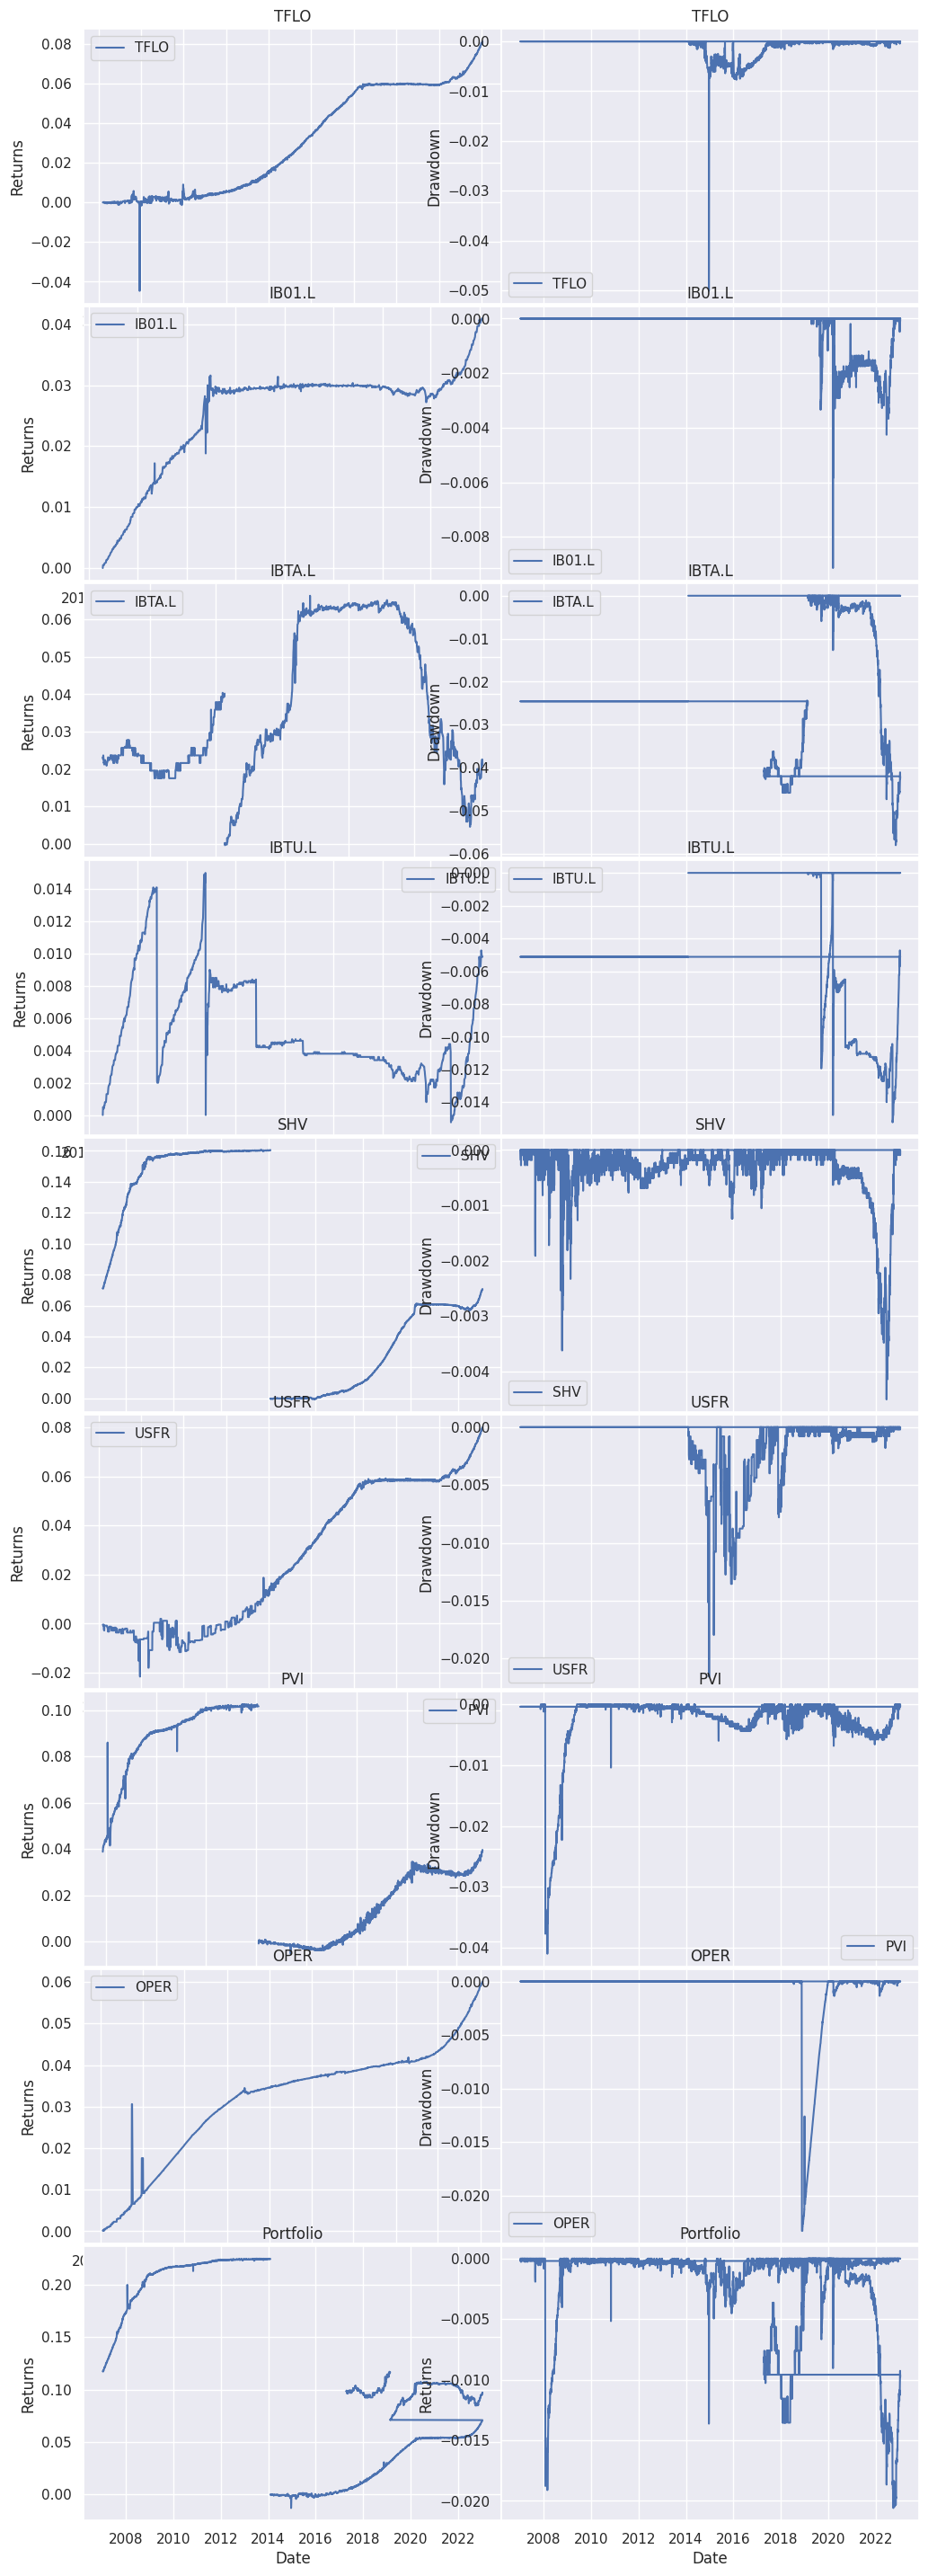

In [9]:
# portfolio = qs.utils.make_index(stocks)
n = stocks.shape[1]+1
# display(n)
portfolio = stocks.mean(axis=1)
fig, ax = plt.subplots(ncols=2, nrows=n,gridspec_kw = {'wspace':0, 'hspace':0.01}, figsize=(12,4*n))
fig.patch.set_facecolor('white')
for i, stock in enumerate(stocks.columns):
    ax[i,0].plot(qs.stats.compsum(stocks[stock]), label=stock)
    ax[i,0].legend()
    ax[i,0].set_title(stock)
    ax[i,0].set_xlabel('Date')
    ax[i,0].set_ylabel('Returns')
    ax[i,1].plot(qs.stats.to_drawdown_series(stocks[stock]), label=stock)
    ax[i,1].legend()
    ax[i,1].set_title(stock)
    ax[i,1].set_xlabel('Date')
    ax[i,1].set_ylabel('Drawdown')
    # ax[i].grid(visible=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
ax[n-1,0].plot(qs.stats.compsum(portfolio), label='Portfolio')
ax[n-1,0].set_title('Portfolio')
ax[n-1,0].set_xlabel('Date')
ax[n-1,0].set_ylabel('Returns')
ax[n-1,1].plot(qs.stats.to_drawdown_series(portfolio), label='Portfolio')
ax[n-1,1].set_title('Portfolio')
ax[n-1,1].set_xlabel('Date')
ax[n-1,1].set_ylabel('Returns')
plt.show()
# qs.plots.snapshot(portfolio, title='Performance')

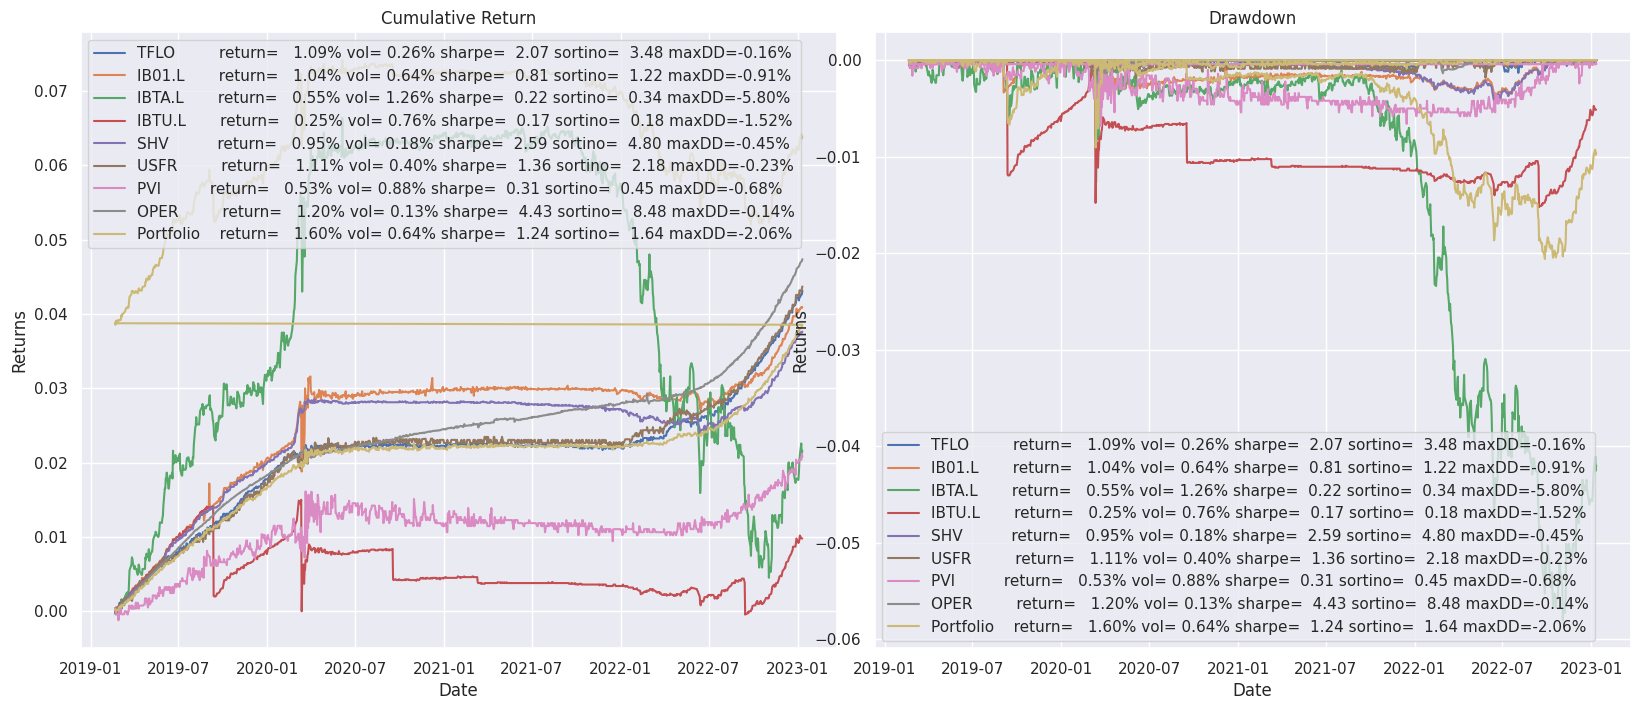

In [10]:
# portfolio = qs.utils.make_index(stocks)
n = stocks.shape[1]+1
# display(n)
labelFormat =  '{:12s} return={:8.2%} vol={:6.2%} sharpe={:6.2f} sortino={:6.2f} maxDD={:6.2%}'
portfolio = stocks.mean(axis=1)
fig, ax = plt.subplots(ncols=2, nrows=1,gridspec_kw = {'wspace':0.05, 'hspace':0.01}, figsize=(20,8))
fig.patch.set_facecolor('white')
for i, stock in enumerate(stocks.columns):
    relevantData = stocks[stock].loc[stocks[stock].index>=maxStartDate]
    relevantLabel = labelFormat.format(stock,qs.stats.cagr(relevantData),qs.stats.volatility(relevantData),qs.stats.sharpe(relevantData),qs.stats.sortino(relevantData),qs.stats.max_drawdown(relevantData))
    ax[0].plot(qs.stats.compsum(relevantData), label=relevantLabel)
    ax[0].set_title(stock)
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Percent Return')
    ax[1].plot(qs.stats.to_drawdown_series(relevantData), label=relevantLabel)
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Percentage Drawdown')
relevantData = portfolio.loc[portfolio.index>=maxStartDate]
relevantLabel = labelFormat.format('Portfolio',qs.stats.cagr(relevantData),qs.stats.volatility(relevantData),qs.stats.sharpe(relevantData),qs.stats.sortino(relevantData),qs.stats.max_drawdown(relevantData))
ax[0].plot(qs.stats.compsum(relevantData), label=relevantLabel)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns')
ax[0].legend()
ax[0].set_title('Cumulative Return')
ax[1].plot(qs.stats.to_drawdown_series(relevantData), label=relevantLabel)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Returns')
ax[1].legend()
ax[1].set_title('Drawdown')
plt.show()

In [11]:
# additional detail
# qs.stats.compsum(stocks.loc[stocks.index>=maxStartDate])
# for stock in tickerList:
#     display(qs.reports.full(returns=stocks.loc[stocks[stock].index>=maxStartDate,stock]))

In [12]:
# report = qs.reports.metrics(mode='full', returns=stock)

In [13]:
# qs.reports.plots(mode='full', returns=stock) # shows basic/full metrics

In [14]:
# qs.reports.basic(returns=stock) # shows basic metrics and plots

In [15]:
stocks_with_datetimeindex = stocks.copy()
stocks_with_datetimeindex.index = pd.to_datetime(stocks.index.values,utc=True)
# remove timezone
stocks_with_datetimeindex.index = stocks_with_datetimeindex.index.tz_convert(None)

In [16]:
# # for p in vdir(qs.plots):
#     # print(p)

# # display(vdir(qs.reports))
# display(getattr(qs.reports,'full'))
# display(type(getattr(qs.reports,'full')))
# # display(dir(getattr(qs.reports,'full')))
# print(getattr(getattr(qs.reports,'full'),'__code__'))

In [17]:
qs.reports.full(
    returns=stocks_with_datetimeindex['OPER'],
) # shows full metrics and plots

TypeError: full() got an unexpected keyword argument 'fontname'

In [ ]:
# qs.reports.html(returns=stock) # generates a complete report as html